## Training loop (WIP)

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import json
import glob


import numpy as np
import pandas as pd
import sklearn.model_selection
import torch 
import torchvision
import rasterio as rio
import matplotlib.pyplot as plt


from models.resnet18 import ResNet18
from data_handlers.datasets.csv_dataset import CustomDatasetFromCSV 

In [6]:
CSV_PATH=os.path.join('data','wealth_index.csv')
DATA_DIR=os.path.join('data','landsat','')

In [7]:
# Add filenames:
csv = pd.read_csv(CSV_PATH)
csv['filename']=csv.apply(
    lambda row:  str(row['lat'])[:5].replace('.','_')+"_"+str(row.lon)[:5].replace('.','_')+'.tif', axis=1
)
csv = csv.loc[:, ~csv.columns.str.contains('^Unnamed')]
csv.head()

,country,year,month,day,cluster,lat,lon,households,wealthpooled,region,filename
0,angola,2011,NaN,NaN,1,-12.350257,13.534922,36,2.312757,POLYGON ((13.159921646118164 -12.7252569198608...,-12_3_13_53.tif
1,angola,2011,NaN,NaN,2,-12.360865,13.551494,32,2.010293,POLYGON ((13.176493644714355 -12.7358646392822...,-12_3_13_55.tif
2,angola,2011,NaN,NaN,3,-12.613421,13.413085,36,0.877744,POLYGON ((13.038084983825684 -12.9884214401245...,-12_6_13_41.tif
3,angola,2011,NaN,NaN,4,-12.581454,13.397711,35,1.066994,POLYGON ((13.022710800170898 -12.9564542770385...,-12_5_13_39.tif
4,angola,2011,NaN,NaN,5,-12.578135,13.418748,37,1.750153,POLYGON ((13.043747901916504 -12.9531345367431...,-12_5_13_41.tif


In [11]:
# AND SAVE UPDATED CSV
csv.to_csv(CSV_PATH, index=False)

In [29]:
def show_sample(tile, label, swap_br=True):
    tile_rgb = tile[:3,:,:].numpy()
    tile_rgb = tile_rgb.transpose((1,2,0))
    tile_rgb = tile_rgb / tile_rgb.max()
    if swap_br:
        tile_rgb=tile_rgb[:,:,::-1]
    plt.figure()
    plt.imshow((tile_rgb*255).astype(int))
    plt.title('wealth index: '+str(label))
    plt.show()
    return

In [ ]:
# COMPUTE MEAN AND STD OF THE WHOLE DATASET
# (DO IT ONCE)
tile_names=glob.glob(os.path.join('data','landsat','')+'*.tif')
tiles=torch.stack([torch.from_numpy(np.nan_to_num(np.array(rio.open(tile).read())[:,:186,:186])) for tile in tile_names])
means = tiles.view(6, -1).mean(dim=1)
stds = tiles.view(6, -1).std(dim=1)
print(means, stds)
# last output:
# tensor([68.3268, 69.6629, 70.0694, 65.2206, 70.0491, 71.7645],
#    dtype=torch.float64) tensor([19.1748, 21.5378, 24.4049, 19.5573, 21.6538, 23.2899],
#    dtype=torch.float64)

In [40]:
train_transform = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(),
    # torchvision.transforms.Normalize(
    #     mean=[68.3268, 69.6629, 70.0694, 65.2206, 70.0491, 71.7645],
    #     std =[19.1748, 21.5378, 24.4049, 19.5573, 21.6538, 23.2899]
    #     )
)
test_transform  = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    # torchvision.transforms.Normalize(
    #     mean=[68.3268, 69.6629, 70.0694, 65.2206, 70.0491, 71.7645],
    #     std =[19.1748, 21.5378, 24.4049, 19.5573, 21.6538, 23.2899]
    #     )
)

In [42]:
train_dataset = CustomDatasetFromCSV(CSV_PATH, DATA_DIR, transform=train_transform)
test_dataset  = CustomDatasetFromCSV(CSV_PATH, DATA_DIR, transform=test_transform)

In [43]:
splits = sklearn.model_selection.train_test_split(np.arange(len(csv)))
splits 

[array([ 8308,  7353, 21413, ...,  5803,  1818,  6159]),
 array([28157, 20466, 24535, ..., 24395, 29753, 24647])]

In [44]:
train_dataset_ = torch.utils.data.Subset(train_dataset, splits[0])
test_dataset_  = torch.utils.data.Subset(test_dataset, splits[1])

70 torch.Size([6, 224, 224]) -1.2307408


<Figure size 640x480 with 0 Axes>

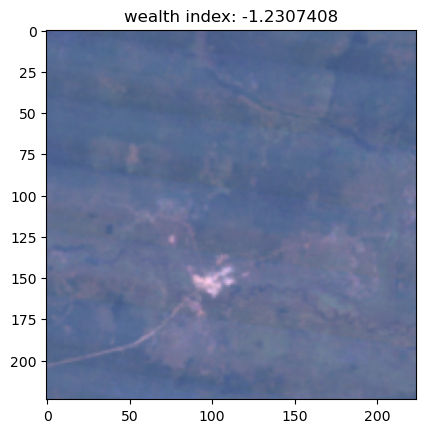

71 torch.Size([6, 224, 224]) -1.1368579


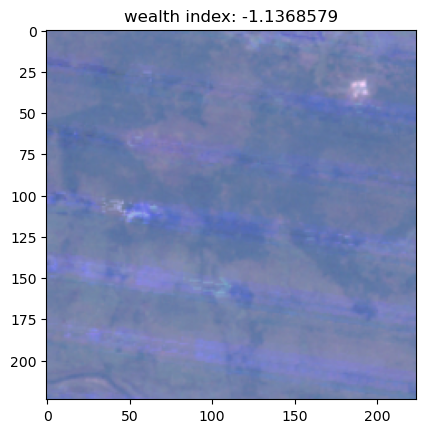

72 torch.Size([6, 224, 224]) -1.3230524


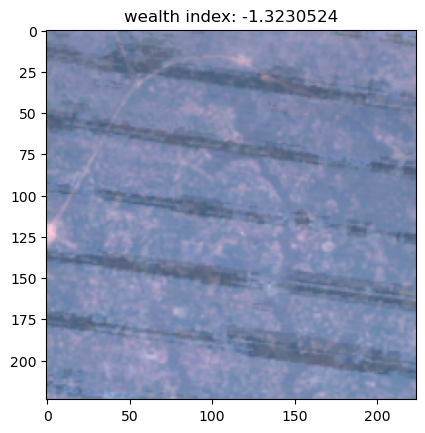

73 torch.Size([6, 224, 224]) -1.3465561


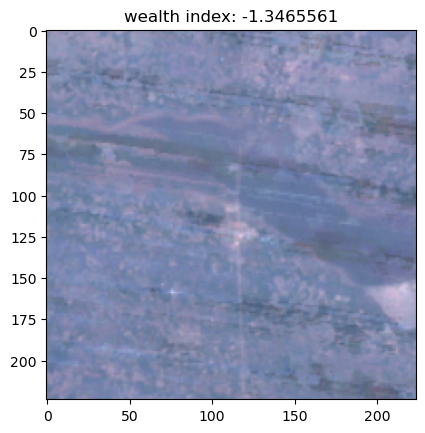

74 torch.Size([6, 224, 224]) -1.1085097


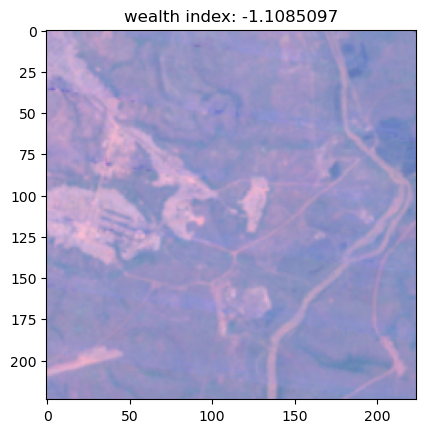

75 torch.Size([6, 224, 224]) -1.0280075


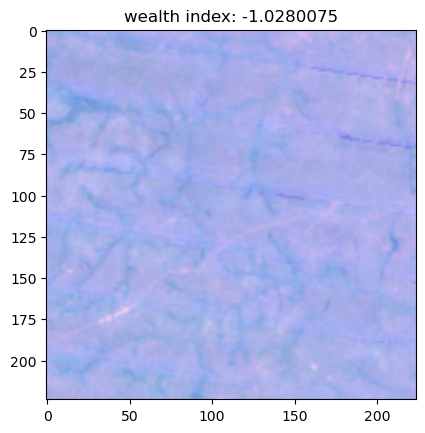

76 torch.Size([6, 224, 224]) -0.22863428


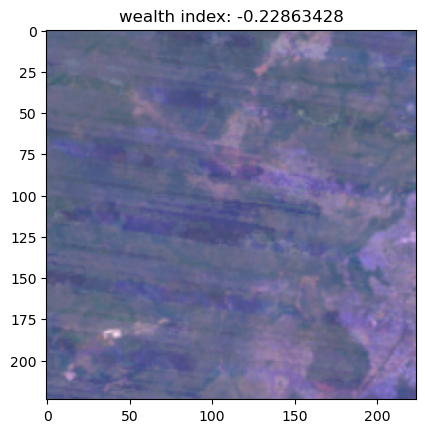

77 torch.Size([6, 224, 224]) -0.87403536


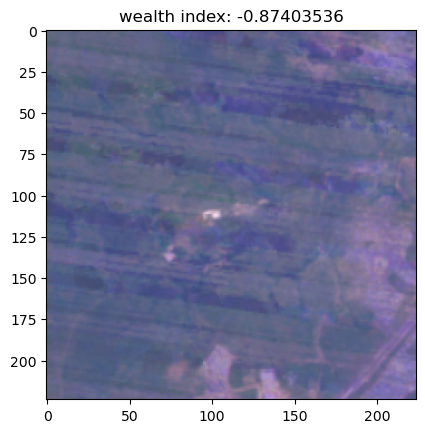

78 torch.Size([6, 224, 224]) -1.1213348


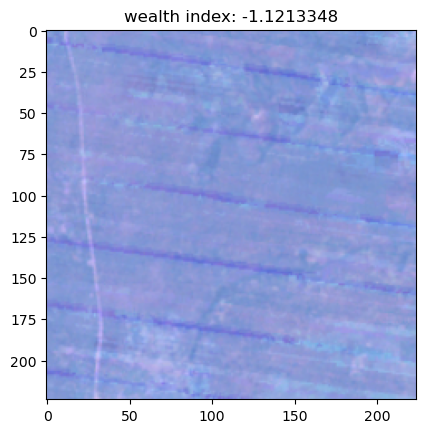

79 torch.Size([6, 224, 224]) -1.2149843


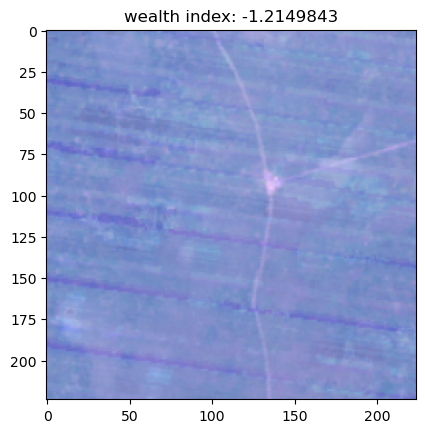

80 torch.Size([6, 224, 224]) -1.0372059


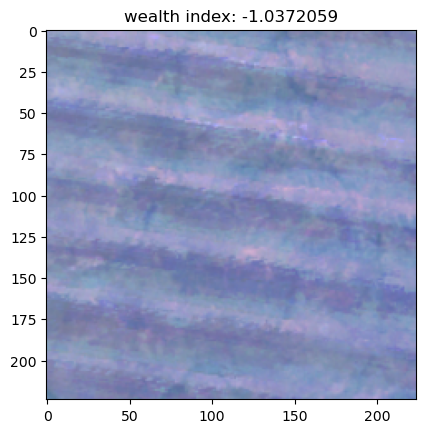

81 torch.Size([6, 224, 224]) -1.2263392


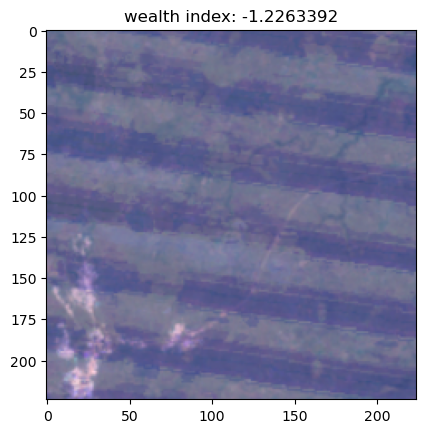

82 torch.Size([6, 224, 224]) -0.6806131


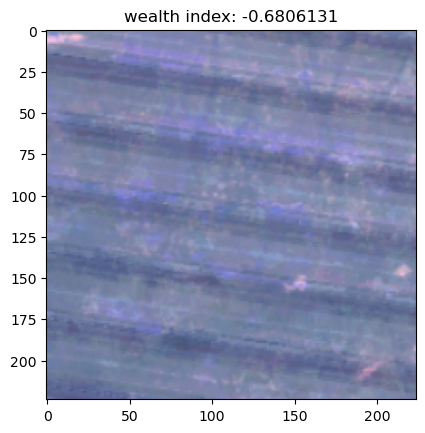

83 torch.Size([6, 224, 224]) -1.1558049


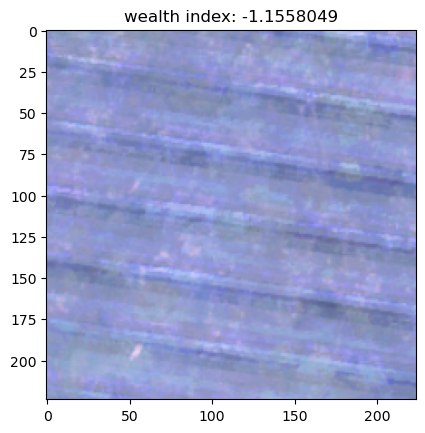

84 torch.Size([6, 224, 224]) -1.1216271


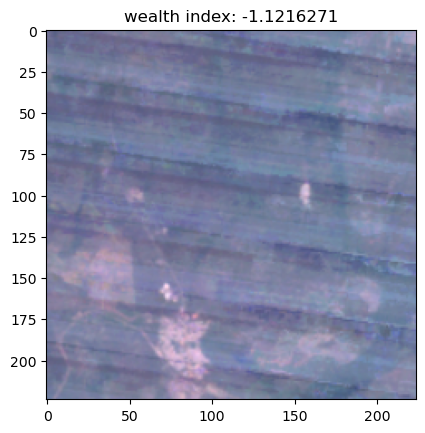

In [45]:
fig = plt.figure()

for i in range(70,85):
    sample = test_dataset[i]
    print(i, sample['tile'].shape, sample['value'])
    show_sample(sample['tile'], sample['value'])

2. Model

In [ ]:
with open('configs/resnet18_ms.json') as f:
    config = json.load(f)
    model = ResNet18(config)
    model.load_checkpoints('models/checkpoints/resnet18_wang_ckpt.pth')

In [ ]:
model.train()

In [ ]:
data = next(iter(loader))
Y = data['wealthpooled']
print(Y, data.shape())

AttributeError: 'dict' object has no attribute 'shape'